In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import spacy 
import textstat
from collections import defaultdict, Counter
from nltk.corpus import stopwords

In [29]:
news = pd.read_excel("Dataset/news_excerpts_parsed.xlsx")
news.head()

,Link,Text
0,https://edition.cnn.com/2023/09/29/business/st...,Starbucks violated federal labor law when it i...
1,https://www.channelnewsasia.com/singapore/su-w...,The first suspect to plead guilty in Singapore...
2,https://edition.cnn.com/2023/05/22/tech/meta-f...,Meta has been fined a record-breaking €1.2 bil...
3,https://www.channelnewsasia.com/singapore/bill...,SINGAPORE: A 45-year-old man linked to Singapo...
4,https://edition.cnn.com/2024/03/05/politics/li...,The Department of Education imposed a record $...


Text(0.5, 1.0, 'Number of characters')

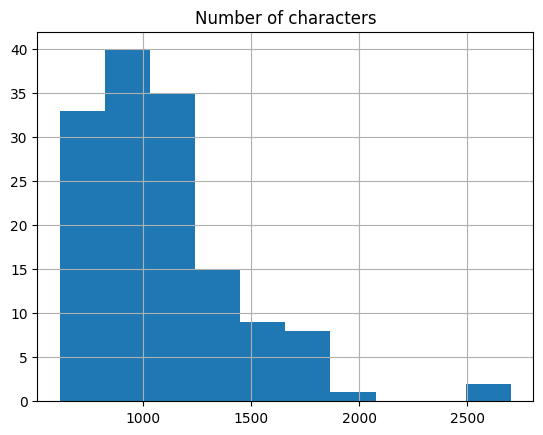

In [3]:
#Histogram of Characters 
news['Text'].str.len().hist()
plt.title("Number of characters")

In [4]:
def plot_word_nums_hist(text):
    text.str.split().map(lambda x: len(x)).hist()

Text(0.5, 1.0, 'Number of words')

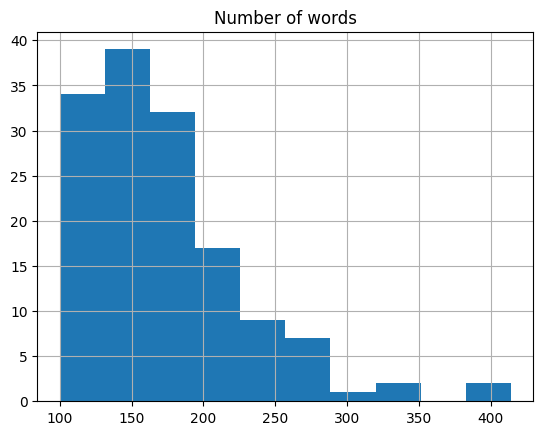

In [5]:
plot_word_nums_hist(news['Text'])
plt.title("Number of words")

In [16]:
# Load English stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yanji\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [17]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

Text(0.5, 1.0, 'Top Stopword Count')

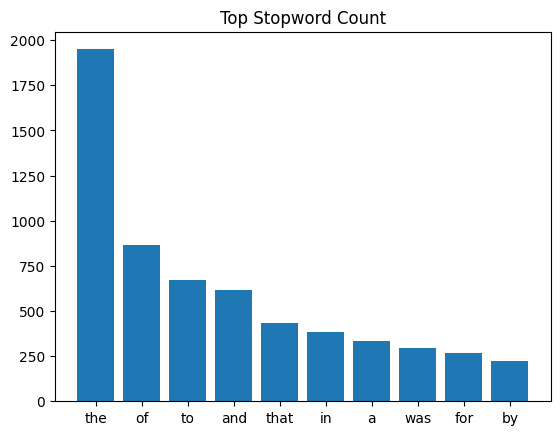

In [18]:
plot_top_stopwords_barchart(news['Text'])
plt.title('Top Stopword Count')

In [19]:
def plot_top_non_stopwords_barchart(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter([word.strip('.,!?;"\'').lower() for word in corpus])
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:60]:
        if word not in stop and word != '–':
            x.append(word)
            y.append(count)
    
    sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Top non-stopwords Count')

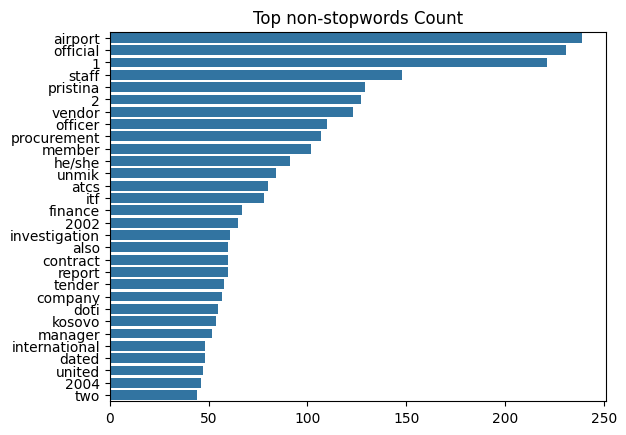

In [20]:
plot_top_non_stopwords_barchart(news['Text'])
plt.title("Top non-stopwords Count")

In [23]:
def plot_top_ngrams_barchart(text, n=2):
    stop = set(stopwords.words('english'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i if word.lower() not in stop]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams = _get_top_ngram(corpus, n)[:10]
    x, y = map(list, zip(*top_n_bigrams))
    sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Top Bigram Count')

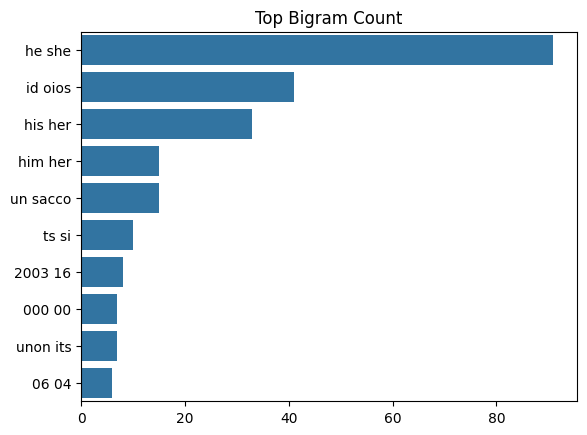

In [24]:
plot_top_ngrams_barchart(news['Text'],2)
plt.title("Top Bigram Count")

Text(0.5, 1.0, 'Top Trigram Count')

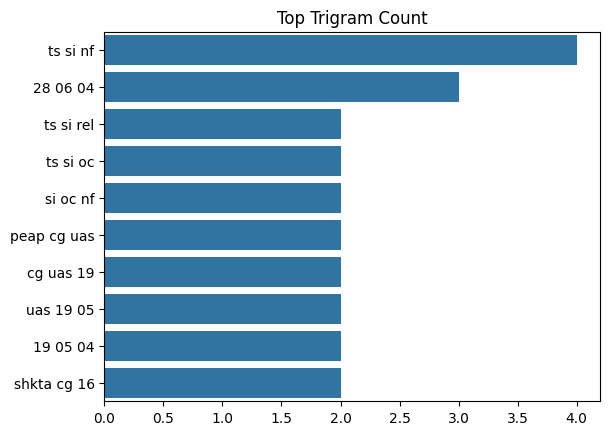

In [25]:
plot_top_ngrams_barchart(news['Text'],3)
plt.title("Top Trigram Count")